# How to use the prebuilt ReAct agent

In this how-to we'll create a simple [ReAct](https://arxiv.org/abs/2210.03629) agent app that can check the weather. The app consists of an agent (LLM) and tools. As we interact with the app, we will first call the agent (LLM) to decide if we should use tools. Then we will run a loop:  

1. If the agent said to take an action (i.e. call tool), we'll run the tools and pass the results back to the agent
2. If the agent did not ask to run tools, we will finish (respond to the user)

<div class="admonition warning">
    <p class="admonition-title">Prebuilt Agent</p>
    <p>
Please note that here will we use a prebuilt agent. One of the big benefits of LangGraph is that you can easily create your own agent architectures. So while it's fine to start here to build an agent quickly, we would strongly recommend learning how to build your own agent so that you can take full advantage of LangGraph.
    </p>
</div>   

## Setup

First let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Code

In [1]:
# First we initialize the model we want to use.
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)


# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal

from langchain_core.tools import tool


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]


# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(model, tools=tools)

## Usage

First, let's visualize the graph we just created

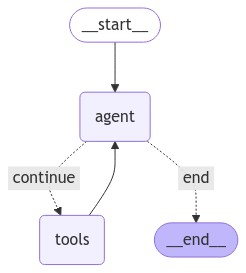

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

Let's run the app with an input that needs a tool call

In [6]:
inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_jgO5OOUnugRkhRi3wAOHl8Et)
 Call ID: call_jgO5OOUnugRkhRi3wAOHl8Et
  Args:
    city: sf
================================= Tool Message =================================
Name: get_weather

It's always sunny in sf
================================== Ai Message ==================================

The weather in San Francisco is currently sunny.


Now let's try a question that doesn't need tools

In [7]:
inputs = {"messages": [("user", "who built you?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

who built you?
================================== Ai Message ==================================

I was created by OpenAI, a research organization focused on developing and advancing artificial intelligence technology.
